# Homework project for the "Differential Equations" course module

1. Solve the wave equation `dt^2 u(t,x) = dx^2 u(t,x)` numerically. Use a `1+1`-dimensional domain, and use Dirichlet boundary conditions `u(t,-L) = u(t,+L) = 0`. Use the spatial domain bounds `[-1; +1]`, and use the Gaussian-like function `f(t,x) = A exp(-1/2 sin(2pi (x-t))^2 / W^2)` as initial condition. Use `L=1, A=1, W=0.2` as parameters. Evolve from `t=0` to `t=4L`, i.e. for two crossing times. Plot the result.

2. Vary the time step size `dt`. If you choose `dt` too large, the discrete system will be unstable. What is the stability limit? Why does this happen? How could you avoid this limit?

3. The energy density of a scalar wave is `epsilon(t,x) = 1/2 ((d/dt u(t,x))^2 + ((d/dx u(t,x))^2)`. Calculate the energy density as a function of space and time for your solution. Plot the result.

4. To calculate the total energy `E(t)` as a function of time, you need to integrate it over space. One way to do so is using the function below. Calculate and show the total energy `E(t)` as a function of time. How well is the energy conserved? How does this depend on the grid spacings `dx` and `dt?

In [3]:
using CairoMakie

In [4]:
# Define two grid functions `t`, `x` holding the coordinates
function coords(nn, ni, dt, dx, L)
    t = [n * dt for i in 0:ni, n in 0:nn]
    x = [(i * dx) - L for i in 0:ni, n in 0:nn]
    return t, x
end

coords (generic function with 1 method)

In [88]:
L = 1
nn = 401
ni = 200
dt = 4*L / nn
dx = 2*L / ni
t, x = coords(nn, ni, dt, dx, L);

## 2.

If we vary dt, the system may become unstable.   
If the recursive amplitude of u is too large, after many iterations, it diverges.   
Why does this happen? Because (a)^n where a>1 diverges as n gets large.
To stop this from happening, we need to be below the CFL limit   
CFL = Δt/Δx > 1 diverges, < 1 is okay.   
Note, dt/dx = 2ni/nn.   
This means for dt/dx to be < 1, 2ni < nn.
Above we have chosen nn as 401 and ni as 200, so nn is more than twice ni.

In [89]:
# Define initial conditions for a standing wave - change these
function standing(t, x)
    ni, nn = size(t)
    u = zeros(ni,nn)
    
    L=1
    A=1
    W=0.2
    
    # initial conditions for the first two points in time
    for n in 1:2, i in 1:ni
        #u[i,n] = cos(2π * t[i,n]) * sin(2π * x[i, n])
        
        u[i,n] = A * exp(-1/2 * sin(2pi * (x[i, n]-t[i,n]))^2 / W^2)
        
        #f(t,x) = A exp(-1/2 sin(2pi (x-t))^2 / W^2)
    end
    return u
end

standing (generic function with 1 method)

In [90]:
u = standing(t,x);

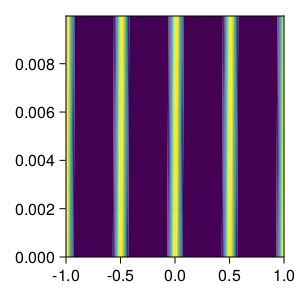

In [91]:
fig = Figure(resolution = (300,300))
ax = Axis(fig[1,1])
contourf!(vec(x[:,1:2]), vec(t[:,1:2]), vec(u[:,1:2]))
fig

In [92]:
# Find the solution at one interior point `u[i,n]`
function evolve_point!(u, dt, dx, n, i)
    ni, nn = size(u)
    # Finite difference for second derivative in x direction at point [i,n-1]
    uxx = (u[i-1,n-1] - 2*u[i,n-1] + u[i+1,n-1]) / dx^2
    # Time derivative
    # utt = (u[i,n-2] - 2*u[i,n-1] + u[i,n]) / dt^2
    # Wave equation
    # utt = uxx
    # Solve for u[i,n]
    u[i,n] = uxx*dt^2 - u[i,n-2] + 2*u[i,n-1]
    return
end

evolve_point! (generic function with 1 method)

In [93]:
# Find the solution for one point in time `n`
function evolve_step!(u, dt, dx, n)
    ni, nn = size(u)
    # Apply boundary condition at left boundary
    u[1,n] = 0
    # Evolve interior
    for i in 2:ni-1
        evolve_point!(u, dt, dx, n, i)
    end
    # Apply boundary condition at right boundary
    u[ni,n] = 0
    return
end

evolve_step! (generic function with 1 method)

In [94]:
# Find the solution everywhere
function evolve!(u, dt, dx)
    ni, nn = size(u)
    # Loop over all times
    for n in 3:nn
        evolve_step!(u, dt, dx, n)
    end
    return
end

evolve! (generic function with 1 method)

In [95]:
evolve!(u, dt, dx)

## 1.

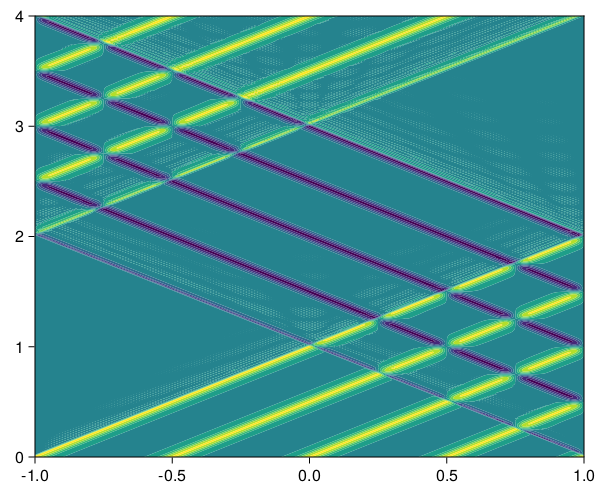

In [96]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(u))
fig

## 3.

Let's start with taking the temporal and the spacial derivative of u(t,x). We'll use the midpoint derivative, and therefore leave off the endpoints.

In [109]:
function epsilon_func(ni, nn, u, dx, dt)
    
    ux = zeros(ni+1,nn+1)
    ut = zeros(ni+1,nn+1)

    for i in 2:ni-1
        ux[i,:] = (u[i+1,:] .- u[i-1,:]) ./ (2*dx)
    end

    for n in 2:nn-1
        ut[:,n] = (u[:,n+1] .- u[:,n-1]) ./ (2*dt)
    end 
    
    epsilon = 0.5 * (ux.^2 + ut.^2)
    
    return epsilon
end

epsilon_func (generic function with 1 method)

In [110]:
ϵ = epsilon_func(ni, nn, u, dx, dt);

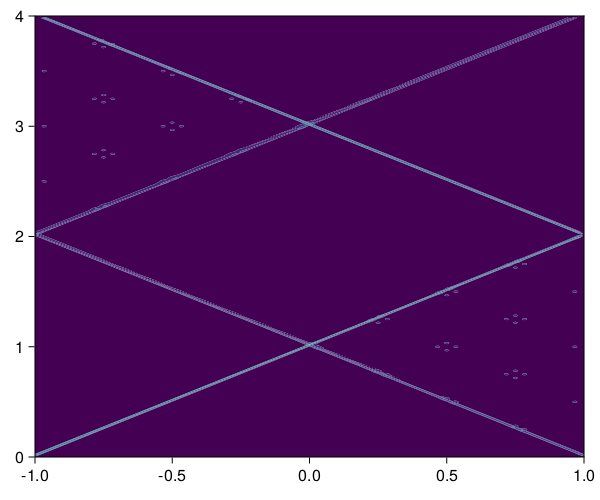

In [111]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(ϵ))
fig

4. To calculate the total energy `E(t)` as a function of time, you need to integrate it over space. One way to do so is using the function below. Calculate and show the total energy `E(t)` as a function of time. How well is the energy conserved? How does this depend on the grid spacings `dx` and `dt?

## 4.

In [100]:
# Integrate `epsilon` over space
# looks like this function is for a specific time step n
function integrate(epsilon, n, dx)
    ni, nt = size(epsilon)
    # The boundary points are special; they have a weight of 1/2.
    # There are `ni` points overall, and the grid spacing is `dx = 2L/(ni-1)`.
    # Integrating the constant function `epsilon=1` thus gives exactly `2L`.
    E = epsilon[1, n] / 2
    for i in 2:ni-1
        E += epsilon[i, n]
    end
    E += epsilon[ni, n] / 2
    # Scale by the grid spacing
    E *= dx
    return E
end

integrate (generic function with 1 method)

In [101]:
function energy_func_of_t(epsilon, dx)

    E_of_t = zeros(nn)
    for j in 1:nn
        E_of_t[j] = integrate(epsilon, j, dx)
    end
    
    return E_of_t
end

energy_func_of_t (generic function with 1 method)

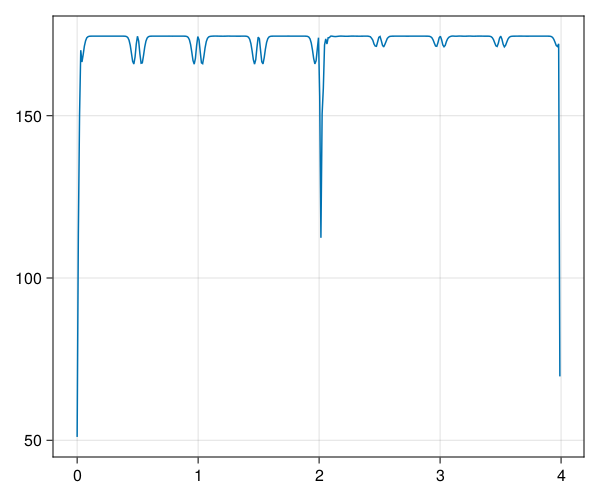

In [107]:
energy_of_t = energy_func_of_t(ϵ,dx);

fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
lines!(t[1,1:nn], energy_of_t)
fig

In [115]:
L = 1
nn = 21
ni = 10
dt = 4*L / nn
dx = 2*L / ni
t, x = coords(nn, ni, dt, dx, L);

In [116]:
u = standing(t,x)
evolve!(u, dt, dx)
ϵ = epsilon_func(ni, nn, u, dx, dt);
energy_of_t = energy_func_of_t(ϵ,dx);

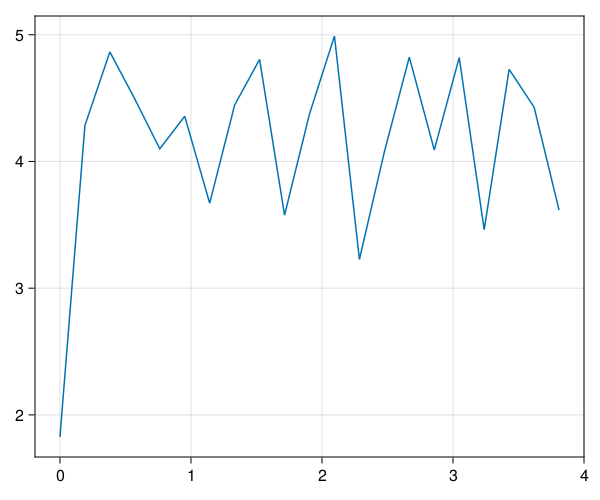

In [117]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
lines!(t[1,1:nn], energy_of_t)
fig

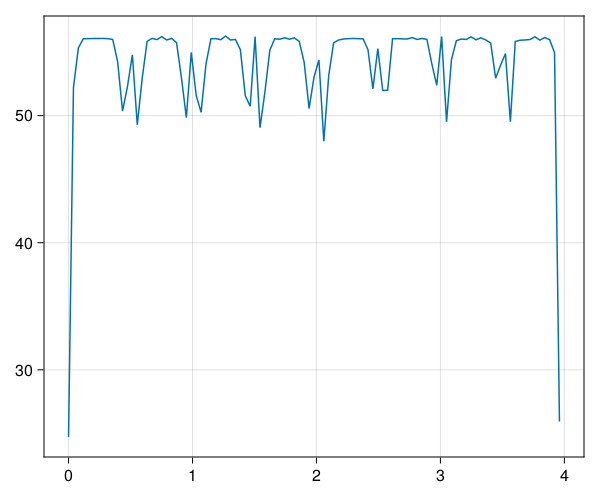

In [118]:
L = 1
nn = 101
ni = 50
dt = 4*L / nn
dx = 2*L / ni
t, x = coords(nn, ni, dt, dx, L)

u = standing(t,x)
evolve!(u, dt, dx)
ϵ = epsilon_func(ni, nn, u, dx, dt)
energy_of_t = energy_func_of_t(ϵ,dx)

fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
lines!(t[1,1:nn], energy_of_t)
fig

Not sure why the energy changes so much for different dx and dt spacings, but you can see that the energy conservation is worse with wider dx and dt spacings and better with smaller dx and dt spacings.